In [1]:
%matplotlib inline

# Ciclo experimental

Verónica E. Arriola  
[Licencia CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)

$\newcommand{\mat}[1]{\boldsymbol{#1}}$

## Objetivos

* Seguir las diferentes etapas que requiere la preparación de un sistema por aprendizaje automático: **obtención de datos**, **propuesta del espacio de hipótesis**, **entrenamiento**, **selección de la hipótesis**, **prueba**.
* Creación y manejo de los conjuntos de datos: **Entrenamiento**, **validación** y **prueba**.
* Aprender a diagnosticar los problemas de **ajuste pobre** (_underfitting_) y **sobreajuste** (_overfitting_) para un problema de regresión.

## Escenario

<figure>
 <center>
  <img src="figuras/fis_carritoBalistico.jpg" alt="Carrito balístico" style="width:50%">
  <figcaption>Carrito balístico.<br/>  Crédito: Laboratorio de mecánica, Facultad de Ciencias, UNAM.</figcaption>
 </center>    
</figure>

## Generación de datos

### Datos limpios
Generemos datos alrededor de un tiro parabólico, lanzado desde la posición $(x_0,y_0)$, en un ángulo $\alpha$, con velocidad inicial $v_0$:

\begin{align}
    y(t) &= y_0 + v_{0}\sin(\alpha) t - \frac{1}{2}gt^2 \\
    x(t) &= x_0 + v_{0}\cos(\alpha) t \\
\end{align}

Para calcular la trayectoria hasta que el proyectil toque el suelo, el tiempo final debe ser:
\begin{align}
    t_f = \dfrac{v_{0}\sin\alpha + \sqrt{(v_{0}\sin\alpha)^2 + 2g y_0}}{g}
\end{align}

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

In [3]:
def genera_parábola(x0,y0,v0,alfa,g,numPuntos=50):
    """
    Genera coordenadas (x,y) al evaluar la ecuación de la parábola con los
    parámetros indicados.
    """
    t0 = 0
    b = v0 * np.sin(alfa)
    tf = (b + np.sqrt(np.square(b) + 2 * g * y0)) / g
    t = np.linspace(0, tf,numPuntos)
    x = t * (v0 * np.cos(alfa)) + x0
    y = t * (v0 * np.sin(alfa)) - ((t * t) * (g/2)) + y0
    return x, y

def grafica_parábola(x, y, line=True):
    """
    Crea la gráfica de la parábola descrita por los puntos (x,y).
    """
    if line: plt.plot(x, y, color='C0', lw=2, zorder=1)
    plt.scatter(x, y, color='C1', zorder=2)
    plt.title('Tiro parabólico');
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')

# Sample points
x = None
y = None

# Si las barras no se muestran activar widgets con
# jupyter nbextension enable --py widgetsnbextension
alfaWidget = widgets.FloatSlider(min=0.0, max=math.pi/2, step=0.1, value=math.pi/5)
display(alfaWidget)
@interact(
    x0 = 1,                     # m
    y0 = 2,                     # m
    v0 = 10,                    # m/s
    alfa = alfaWidget,          # radianes
    g = 9.8,                    # m/s^2
    numPuntos = 25
)
def inicializa_parábola(x0,y0,v0,alfa,g,numPuntos):
    global x, y
    x, y = genera_parábola(x0,y0,v0,alfa,g,numPuntos)
    grafica_parábola(x, y)

FloatSlider(value=0.6283185307179586, max=1.5707963267948966)

interactive(children=(IntSlider(value=1, description='x0', max=3, min=-1), IntSlider(value=2, description='y0'…

### Ruido

Ahora desviemos los puntos muestreados en las direcciones $x,y$, añadiendo ruido gaussiano.

Recodemos que la función gaussiana está dada por:
\begin{align}
f(x|\mu=0, \sigma=1) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
\end{align}
donde $\mu$ es la **media** y $\sigma$ es la **desviación estándar**.  $\sigma^2$ es llamada la **varianza**.

Al generar muestras aleatorias utilizando esta función obtenemos el histograma siguiente:

In [4]:
# Asignar la semilla para que todos números aleatorios generados sean siempre los mismos
np.random.seed(5)

@interact(mu=10, sigma=(0.01,4,0.1), muestras=(11,1000))
def grafica_historial_gaussiana(mu=10, sigma=0.1, muestras=1000):
    s = np.random.normal(mu, sigma, muestras)
    # histograma
    count, bins, ignored = plt.hist(s, (int)(muestras/10), density=True, alpha=0.60, edgecolor='C0', lw=2)
    # gaussiana
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='C2')
    plt.title('Distribución normal');
    plt.xlabel('valor')
    plt.ylabel('ejemplares')

interactive(children=(IntSlider(value=10, description='mu', max=30, min=-10), FloatSlider(value=0.1, descripti…

In [5]:
x_ruido = None
y_ruido = None

In [6]:
@interact(sigma=widgets.FloatSlider(min = 0.0001, step =.01, max = 1.0, value = 0.18))
def agrega_ruido(sigma):
    global x, y, x_ruido, y_ruido
    x_ruido = np.random.normal(x, sigma)
    y_ruido = np.random.normal(y, sigma)
    grafica_parábola(x_ruido, y_ruido, False)

interactive(children=(FloatSlider(value=0.18, description='sigma', max=1.0, min=0.0001, step=0.01), Output()),…

## División de los datos

Para poder entrenar y probar nuestro modelo, necesitaremos dividir nuestros datos en tres conjuntos:
* 60% Entrenamiento
* 20% Validación
* 20% Prueba

Los datos para cada conjunto deben ser extraídos aleatoriamente, de entre nuestro conjunto de datos disponible.

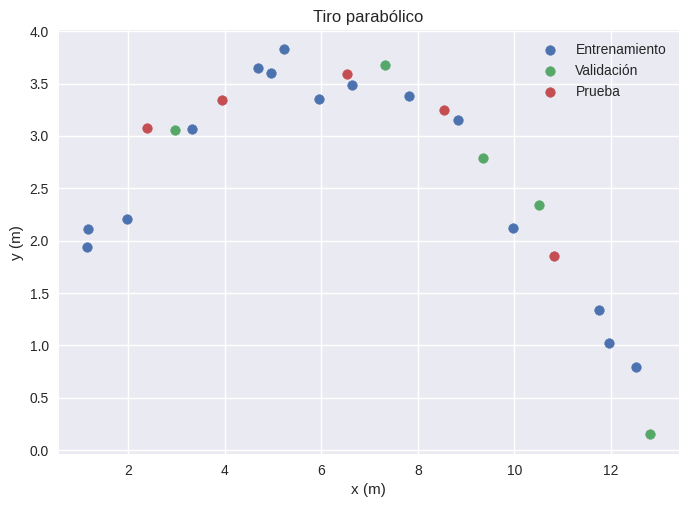

In [7]:
def grafica_parábola_en_grupos(setE, setV, setP):
    xE, yE = setE
    xV, yV = setV
    xP, yP = setP
    plt.scatter(xE, yE, color='C0', label="Entrenamiento")
    plt.scatter(xV, yV, color='C1', label="Validación")
    plt.scatter(xP, yP, color='C2', label="Prueba")
    plt.legend()
    plt.title("Tiro parabólico")
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')

def divide_datos(x, y):
    numDatos = len(x)
    nE = (int)(0.6 * numDatos)    # número de datos de entrenamiento
    nV = (int)(0.2 * numDatos)    # número de datos de validación
    nP = numDatos - (nE + nV)     # número de datos de prueba
    # Elige al azar
    indices = np.arange(numDatos)
    np.random.shuffle(indices)
    xE = indices[:nE].choose(x)
    yE = indices[:nE].choose(y)
    xV = indices[nE:nE+nV].choose(x)
    yV = indices[nE:nE+nV].choose(y)
    xP = indices[nE+nV:].choose(x)
    yP = indices[nE+nV:].choose(y)
    # grafica cómo luce la selección
    grafica_parábola_en_grupos((xE, yE), (xV, yV), (xP,yP))
    return (xE, yE), (xV, yV), (xP,yP)
setE, setV, setP = divide_datos(x_ruido, y_ruido)

def grafica_parábola_2():
    grafica_parábola_en_grupos(setE, setV, setP)

# Entrenamiento

Ya que hemos generado nuestros datos con ruido, el problema es reconstruir un modelo de regresión, que se ajuste adecuadamente a los datos.  Para ajustar el modelo utilizaremos los datos de entrenamiento.

## Espacio de hipótesis

### Regresión polinomial

A partir de este momento, pasaremos a trabajar con los vectores $\vec{x}$ y $\vec{y}$ como matrices $(n + 1) \times 1$, donde $n$ es el grado del polinomio a ajustar.  En el caso de regresión lineal, $n=1$.  Reacomodaremos nuestros datos de la forma siguiente:
\begin{align}
\mat{X} &= \begin{bmatrix}
          1 \vec{x}
          \end{bmatrix} \\
\mat{Y} &= \begin{bmatrix}
          \vec{y}
          \end{bmatrix} \\
\end{align}

In [8]:
# Crear las matrices de datos en numpy

col_forma = (len(setE[0]),1)
print("Dimensiones de cada columna: ", col_forma)

UNOS = np.ones(col_forma)
print(UNOS)

Dimensiones de cada columna:  (15, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [9]:
XE = np.array(setE[0])
print(XE)

[ 4.69194206 12.52672093  4.96414913 11.96423599  1.17567303  8.83937424
  1.14698278  5.95684825  7.82101925  1.98855082  5.22442763  9.97114529
  6.63470699  3.3194972  11.74483149]


In [10]:
# Convertir XE en vector columna
XE = XE.reshape(col_forma)

# Concatenar UNOS y XE
MX = np.column_stack((UNOS, XE))
MX

array([[ 1.        ,  4.69194206],
       [ 1.        , 12.52672093],
       [ 1.        ,  4.96414913],
       [ 1.        , 11.96423599],
       [ 1.        ,  1.17567303],
       [ 1.        ,  8.83937424],
       [ 1.        ,  1.14698278],
       [ 1.        ,  5.95684825],
       [ 1.        ,  7.82101925],
       [ 1.        ,  1.98855082],
       [ 1.        ,  5.22442763],
       [ 1.        ,  9.97114529],
       [ 1.        ,  6.63470699],
       [ 1.        ,  3.3194972 ],
       [ 1.        , 11.74483149]])

In [11]:
# Crear vector columna con las respuestas correctas
YE = np.array(setE[1]).reshape(col_forma)

## TODO: Imprime el valor de YE

Ahora podemos utilizar la fórmula normal para encontrar la pendiente y la ordenada al origen:
\begin{align}
\Theta &= (\mat{X}^T \mat{X})^{-1} \mat{X}^T Y
\end{align}
esto corresponde a ajustar una recta por mínimos cuadrados.

In [12]:
def fórmula_normal(MX, Y):
    """
    Aplica la fórmula normal para ajustar un hiperplano
    """
    xtx_inv = np.linalg.inv(np.dot(MX.T, MX))
    Theta = np.dot(np.dot(xtx_inv, MX.T), Y)
    return Theta

[[b],[m]] =


array([[ 3.36847584],
       [-0.11739981]])

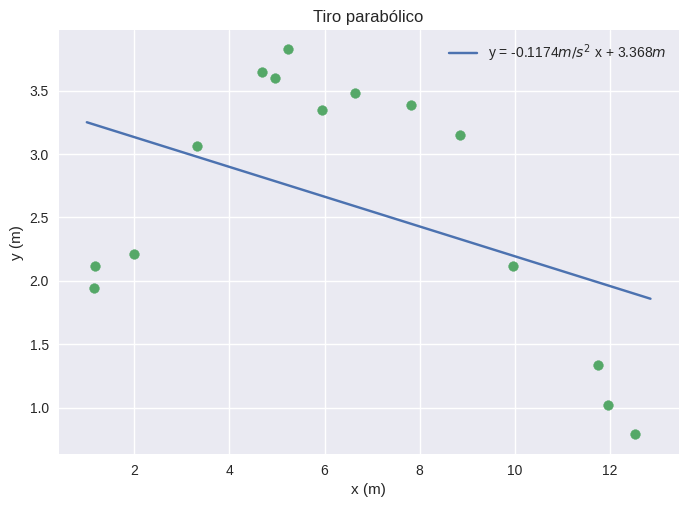

In [13]:
def ajusta_recta(MX, Y):
    Theta = fórmula_normal(MX, Y)
    grafica_parábola([MX[:,1]],[Y],False)
    ry = x * Theta.item(1) + Theta.item(0)
    line = plt.plot(x, ry, label="y = {0:.4}$m/s^2$ x + {1:.4}$m$".format(Theta.item(1), Theta.item(0)) )
    plt.legend(handles=line, loc=1)
    return Theta
print("[[b],[m]] =")
ajusta_recta(MX, YE)

Decimos que una recta ofrece un ajuste pobre para este tipo de datos pues el modelo es demasiado simple para ajustarse correctamente a los datos de entrenamiento.

<div class="alert alert-danger">
 Decimos que el <b>ajuste es pobre</b> cuando el error es grande aún después del proceso de minimización.
</div>

### Regresión multivariada

Veamos ahora qué sucede si intentamos ajustar polinomios de grado creciente a nuestros datos.

Sea la familia de hipótesis:
\begin{align}
h_{\Theta}(x) &= \theta_0 + \theta_1 x \\
h_{\Theta}(x) &= \theta_0 + \theta_1 x + \theta_2 x^2 \\
h_{\Theta}(x) &= \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 \\
... \\
h_{\Theta}(x) &= \theta_0 + \theta_1 x + \theta_2 x^2 + ... + \theta_n x^n \\
\end{align}

Y la función de error:
\begin{align}
Error &= \frac{1}{2m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)})-y^{(i)})^2
\end{align}

Si pensamos en los términos $x^i$ como características adicionales $x_i = x^i$ a nuestros datos de entrada, podemos utilizar la fórmual general que se muestra a continuación, con la ecuación normal para ajustar el modelo:

\begin{align}
 h_\theta(x) &= \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n \\
 x_0 &\equiv 1 \\
 h_\theta(x) &= \Theta^T X = X^T \Theta
\end{align}
con
\begin{align}
\mat{X} &= \begin{bmatrix}
       x_0^{(1)} x_1^{(1)} ... x_n^{(1)}  \\
       x_0^{(2)} x_1^{(2)} ... x_n^{(2)}  \\
       ...\\
       x_0^{(m)} x_1^{(m)} ... x_n^{(m)}
      \end{bmatrix} &
  \Theta &= \begin{bmatrix}
             \theta_0 \\
             \theta_1 \\
             ... \\
             \theta_n
            \end{bmatrix} &
  Y &= \begin{bmatrix}
       y_0 \\
       y_1\\
       ...\\
       y_n
      \end{bmatrix}
\end{align}
La ecuación normal luce igual que en la sección anterior:
\begin{align}
\Theta &= (\mat{X}^T \mat{X})^{-1} \mat{X}^T Y
\end{align}

Cada modelo que ajustemos tendrá $n + 1$ parámetros libres $\theta_i$.

<div class="alert alert-success">
    La complejidad al utilizar un polinomio para realizar una predicción es <b>lineal</b> en el número de términos que tenga el polinomio.
</div>

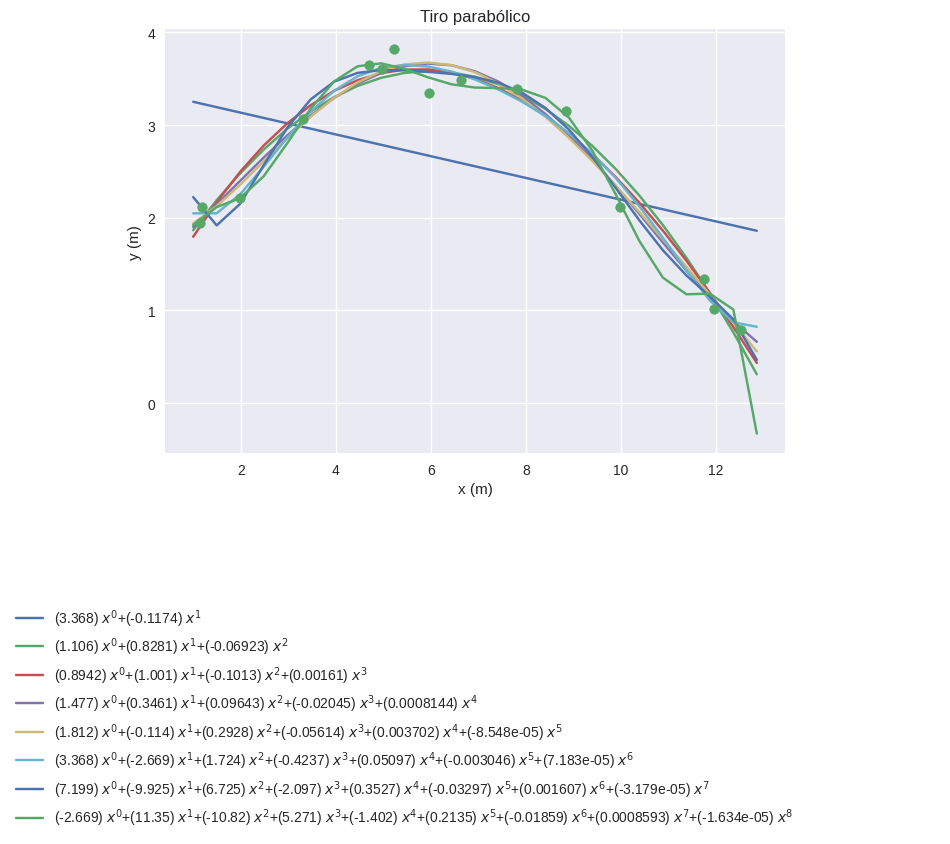

In [14]:
n = 8         # Grado del polinomio más alto a ajustar

def ajusta_polinomios(X, Y, n):
    lista_Theta = []    # Lista de parámetros para cada modelo ajustado
    MX = np.ones(X.shape)
    XI = np.ones(X.shape)        # Vector con las potencias de X
    for i in range(1, n + 1):
        XI = np.multiply(XI, X)
        #print(XI)
        MX = np.column_stack((MX, XI))
        #print(MX)
        lista_Theta.append(fórmula_normal(MX, Y))
    return lista_Theta
lista_Theta = ajusta_polinomios(XE, YE, n) # Lista de coeficientes de menor a mayor potencia
#print(Theta)

def grafica_polinomios(X, Y, ListaTheta):
    grafica_parábola([X],[Y],False)
    for m_Theta in lista_Theta:
        ry = np.polyval(m_Theta[::-1], x) # Requiere los coeficientes de mayor a menor potencia
        label = "+".join(["({0:.4}) $x^{1}$".format(c.item(), i) for i, c in enumerate(m_Theta)])
        line = plt.plot(x, ry, label=label, zorder=1)
    plt.legend(bbox_to_anchor=(-0.25, -0.9, 1.5, 0.), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
grafica_polinomios(XE, YE, lista_Theta)

<div class="alert alert-danger">
 Cuando existe <b>sobreajuste</b> el error en el conjunto de entrenamiento es pequeño, pero el modelo no es adecuado para hacer predicciones sobre datos no vistos.
</div>

# Selección del mejor modelo

Dado que nosotros generamos los datos a partir de una parábola, sabemos qué resultado esperar pero, ¿si realmente estuviéramos tratando de deducirlo a partir de los datos? ¿Cómo elegir el modelo más adecuado?

Ahora utilizaremos los datos del conjunto de **validación** para seleccionar el polinomio más adecuado.

Necesitamos comparar el error que comete el polinomio al predecir los datos del conjunto de entrenamiento, con el error que comete al realizar predicciones sobre datos que **no ha visto**.  Estos los obtendremos del conjunto de validación.

<div class="alert alert-success">
    El $grado$ para el cual el error sea menor en el <b>conjunto de validación</b> es el que selecciona la hipótesis que generaliza mejor a datos nuevos.
</div>

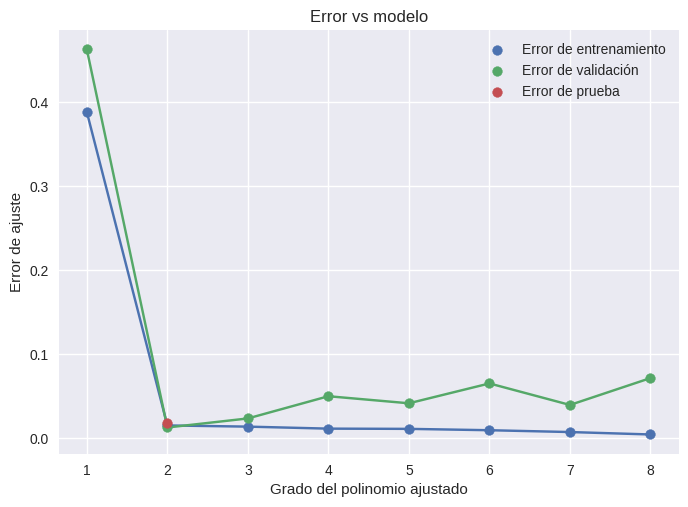

In [15]:
def grafica_errores(lista_Theta, X, Y, color, label):
    grados = []
    errores = []
    for m_Theta in lista_Theta:
        #print("Pars = ", m_Theta[::-1], "\n X=", X) # A1 es la vista como arreglo de la matriz X
        ry = np.polyval(m_Theta[::-1], X).reshape((X.shape[0], 1)) # Requiere los coeficientes de mayor a menor potencia
        #print("try:", ry, '\n', Y)
        temp = (ry - Y)
        error = np.dot(temp.T, temp) / (2*len(temp))
        grados.append(len(m_Theta)-1)
        errores.append(error[0].item())
    plt.scatter(grados, errores, label=label, color=color, zorder=3)
    plt.plot(grados, errores, color=color)
    plt.legend()
    plt.title("Error vs modelo")
    plt.xlabel("Grado del polinomio ajustado")
    plt.ylabel("Error de ajuste")

grafica_errores(lista_Theta, XE, YE, label="Error de entrenamiento", color='C0')

col_forma = (len(setV[0]),1)
XV = np.array(setV[0]).reshape(col_forma)
YV = np.array(setV[1]).reshape(col_forma)
grafica_errores(lista_Theta, XV, YV, label="Error de validación", color='C1')

col_forma = (len(setP[0]),1)
XP = np.array(setP[0]).reshape(col_forma)
YP = np.array(setP[1]).reshape(col_forma)
grafica_errores([lista_Theta[1]], XP, YP, label="Error de prueba", color='C2')


Los primeros puntos, donde el error de entrenamiento y el de validación son altos, corresponden a una región de *ajuste pobre* a los datos.  La región donde el error de entrenamiento baja, pero el de validación permanece arriba corresponde a un *sobre ajuste* (el modelo se ha adherido demasiado al ruido).

El punto donde ambos errores tienen el mismo rango (mínimo del error de validación) nos indica el modelo que nos puede convenir más.  En este caso: el polinomio de segundo grado.

El punto verde, que no fue utilizado para tomar ninguna decisión, nos da un estimado sobre el error que podremos esperar al utilizar nuestro modelo elegido sobre otros datos no vistos.

Entre más datos tengamos en cada grupo, mejores serán las estimaciones obtenidas.

# Regularización

En lugar de probar con polinomios de grados distintos, se propone un polinomio de grado muy alto y se agrega un término de penalización a la función de error, de modo que coeficientes con magnitudes grandes sean rechazados.  Ahora se debe elegir qué tan fuerte es esta penalización.

La nueva función de error utiliza regularización **L2**:
\begin{align}
 Error &= \frac{1}{2m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)})-y^{(i)})^2 + \lambda \Theta^T\Theta
\end{align}

La nueva forma normal vectorizada se ve como:
\begin{align}
 \Theta &= (\mat{X}^T \mat{X} + \lambda \mat{K})^{-1}\mat{X}^T Y
\end{align}

In [16]:
def fórmula_normal_reg(MX, Y, lm, K):
    """
    Aplica la fórmula normal con regularización para ajustar un hiperplano
    K: matriz identidad
    """
    xtx_inv = np.linalg.inv(np.dot(MX.T, MX) + lm * K)
    Theta = np.dot(np.dot(xtx_inv, MX.T), Y)
    return Theta

In [17]:
vlambda=(0,20,25) # intervalo de valores para el parámetro de regularización y num de puntos generados.
lambdas = np.linspace(*vlambda)
def ajusta_polinomio_reg(X, Y):
    #print(X)
    lista_Theta = []    # Lista de parámetros para cada modelo ajustado
    MX = np.ones(X.shape)
    XI = np.ones(X.shape)        # Vector con las potencias de X
    for i in range(1, n+1):
        XI = np.multiply(XI, X)
        MX = np.column_stack((MX, XI))
    #print(MX)
    K = np.eye(n+1)
    for lm in lambdas:
        lista_Theta.append(fórmula_normal_reg(MX, Y, lm, K))
    return lista_Theta

lista_Theta_reg = ajusta_polinomio_reg(XE, YE) # Lista de coeficientes de menor a mayor potencia

<div class="alert alert-success">
    El $\lambda$ para el cual el error sea menor en el <b>conjunto de validación</b> es el que selecciona la hipótesis que generaliza mejor a datos nuevos.
</div>

Lambda óptima: lambda = 5.0


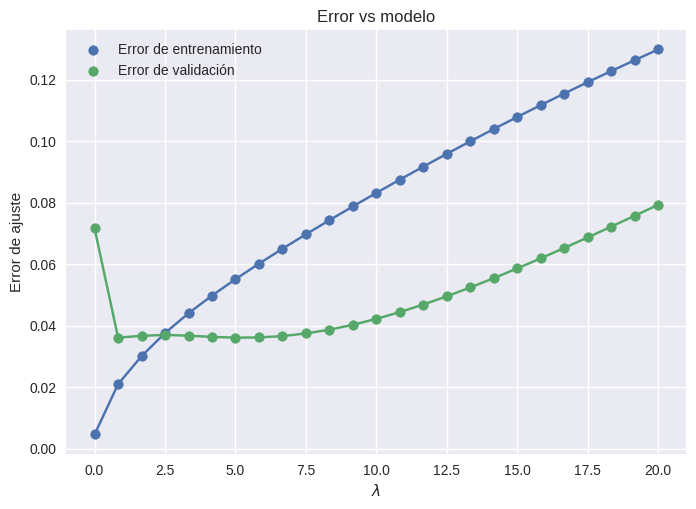

In [18]:
def grafica_errores_reg(lista_Theta, X, Y, color, label):
    errores = []
    for m_Theta in lista_Theta: # A1 es la vista como arreglo de la matriz X
        ry = np.polyval(m_Theta[::-1], X).reshape((X.shape[0], 1)) # Requiere los coeficientes de mayor a menor potencia
        temp = (ry - Y)
        error = np.dot(temp.T, temp) / (2*len(temp))
        errores.append(error[0].item())
    plt.scatter(lambdas, errores, label=label, color=color, zorder=3)
    plt.plot(lambdas, errores, color=color)
    plt.legend()
    plt.title("Error vs modelo")
    plt.xlabel("$\lambda$")
    plt.ylabel("Error de ajuste")
    return np.argmin(errores)
    
grafica_errores_reg(lista_Theta_reg, XE, YE, label="Error de entrenamiento", color='C0')
minimo = grafica_errores_reg(lista_Theta_reg, XV, YV, label="Error de validación", color='C1')
print("Lambda óptima: lambda =", lambdas[minimo])
#graficaErroresReg([ListaThetaReg[minimo]], XP, YP, label="Error de prueba", color=colores[2])

In [19]:
poly_reg = r"+".join([r"({0:.4}) x^{1}".format(c.item(), i) for i, c in enumerate(lista_Theta_reg[minimo])])
from IPython.display import display, Math
display(Math(poly_reg))

<IPython.core.display.Math object>